# **SentimentArcs (Part 5): Time Series Feature Analysis**

By: Jon Chun
12 Jun 2021

References:

* Coming...

TODO:
* Demo datafiles
* Error detection around Crux points context (out of bounds)
* lex_discrete2continous (research binary->gaussian transformation fn)
* Text Preprocessing hints/tips/flowchart
* Clearly document workflow and partition across notebooks/libraries
* Code review and extraction to libraries
* Corpus ingestion for any format
* XAI (mlm false peak 1717SyuzhetR/1732SentimentR/1797robertalg15 adam watches war argument at dinner) 
* Centralize and Standardize Model name lists
* Normalize model SA Series lengths
* Standardize all SA Series with the same method
* Seamless report generation/file saving
* Get raw text from SentimentR
* Filter out non-printable characters
* Roll-over Crux-Points (SentNo+Sent/Parag) (plotly)
* Label/Roll-over Chapter/Sect No at Boundries
* Generate Report PDF/csv
* Option to select raw or discrete2continous transformation (Bing)
* Annotation functionality + Share/Collaboration of findings/reseearch
* clusters, centroids = kmeans1d.cluster(np.array(corpus_sentimentr_df['jockers_rinker']), k)
* plotly prefered library to save dynamic images: kaleido
* Correlation heatmaps: Justify choice of Spearman, Pearson, or other algo

Facts:
* SyuzhetR vs SentimentTime Clean/Preprocess
* V.Woolf - To The Lighthouse
* SyuzhetR Clean: 3511 (SyuzhetR Preprocessed) Sentences (SentimentTime Preprocessed) 3403
* SentimentTime Clean: (Raw) 3402  (Clean) 3402


Preprocessing of Corpus Textfile
* Put headers in ALL CAPS
* Put \n\n between each CHAPTER/BOOK or SECTION header or Paragraphs
* Keep your format/spacing consistent
* Try to use utf-8 (not cp1252 (e.g. \n <- \n\r)
* No leading blank lines, one trailing blank line at end of textfile
* Check for illegal, non-printable or other problematic code (e.g. curly single/double quotes)

# **Reference Code**

Surveys:
* https://github.com/prrao87/fine-grained-sentiment (20210409) Fine-grained SA (7 Models)


Other:
* https://github.com/annabiancajones/GA_capstone_project/blob/master/part3_mine_refine.ipynb
* https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6 CV

# **[RESTART RUNTIME] May be Required for these Libaries**

In [1]:
# [RESTART RUNTIME] May be Required (only needed for Plotly)

# Designed Security Hole in older version of PyYAML, must upgrade to use plotly

!pip install pyyaml==5.4.1

     |████████████████████████████████| 636 kB 14.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# [STEP 1] Manual Configuration

## [INPUT] Connect Google gDrive to this Jupyter Notebook

In [2]:
# [INPUT REQUIRED]: Authorize access to Google gDrive

# Connect this Notebook to your permanent Google Drive
#   so all generated output is saved to permanent storage there

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("Attempting to attach your Google gDrive to this Colab Jupyter Notebook")
  drive.mount('/gdrive')
else:
  print("Your Google gDrive is attached to this Colab Jupyter Notebook")

Attempting to attach your Google gDrive to this Colab Jupyter Notebook
Mounted at /gdrive


In [3]:
# [CUSTOMIZE]: Change the text after the Unix '%cd ' command below (change directory)
#              to math the full path to your gDrive subdirectory which should be the 
#              root directory cloned from the SentimentArcs github repo.

# NOTE: Make sure this subdirectory already exists and there are 
#       no typos, spaces or illegals characters (e.g. periods) in the full path after %cd

# NOTE: In Python all strings must begin with an upper or lowercase letter, and only
#         letter, number and underscores ('_') characters should appear afterwards.
#         Make sure your full path after %cd obeys this constraint or errors may appear.



# Step #1: Get full path to SentimentArcs subdir on gDrive
# =======
#@markdown **Accept default path on gDrive or Enter new one:**

Path_to_SentimentArcs = "/gdrive/MyDrive/cdh/sentiment_arcs/" #@param ["/gdrive/MyDrive/sentiment_arcs/"] {allow-input: true}

#@markdown (e.g. /gdrive/MyDrive/research/sentiment_arcs/)



# Step #2: Move to Parent directory of Sentiment_Arcs
# =======
parentdir_sentiment_arcs = '/'.join(Path_to_SentimentArcs.split('/')[:-2])
print(f'subdir_parent: {parentdir_sentiment_arcs}')
%cd $parentdir_sentiment_arcs


# Step #3: If project sentiment_arcs subdir does not exist, 
#          clone it from github
# =======
import os

if not os.path.isdir('sentiment_arcs'):
  # NOTE: This will not work until SentimentArcs becomes an open sourced PUBLIC repo
  # !git clone https://github.com/jon-chun/sentiment_arcs.git

  # Test on open access github repo
  !git clone https://github.com/jon-chun/nabokov_palefire.git


# Step #4: Change into sentiment_arcs subdir
# =======
%cd ./sentiment_arcs
# Test on open acess github repo
# %cd ./nabokov_palefire

# Step #5: Confirm contents of sentiment_arcs subdir
# =======
!ls 

subdir_parent: /gdrive/MyDrive/cdh
/gdrive/MyDrive/cdh
/gdrive/MyDrive/cdh/sentiment_arcs
 all_novels_new_4syuzhetr.json
 catboost_info
 config
 data
 docs
 huliu.rda
'IMDB Dataset.csv'
 imdb-dataset-of-50k-movie-reviews.zip
 jockersrinker.rda
 lexicons
 lmcd.rda
 loughranmcdonald.rda
 models__info.yaml
 notebooks
 nrc.rda
 old_sentiment_raw_novels_new_lex_ml_dnn.json
 plots
 senticnet.rda
 sentiment_clean
 sentiment_raw
 sentinet.rda
 sentiword.rda
 SentiWord.rda
 text_clean
 text_raw
 utils
 v0.9.2.zip
 v0.9.2.zip.1
 v0.9.2.zip.2


## [INPUT] Define Directory Tree Structure

In [4]:
# [CUSTOMIZE]: Change the text after the Unix '%cd ' command below (change directory)
#              to math the full path to your gDrive subdirectory which should be the 
#              root directory cloned from the SentimentArcs github repo.

# NOTE: Make sure this subdirectory already exists and there are 
#       no typos, spaces or illegals characters (e.g. periods) in the full path after %cd

# NOTE: In Python all strings must begin with an upper or lowercase letter, and only
#         letter, number and underscores ('_') characters should appear afterwards.
#         Make sure your full path after %cd obeys this constraint or errors may appear.



# Step #1: Get full path to SentimentArcs subdir on gDrive
# =======
#@markdown **Accept default path on gDrive or Enter new one:**

Path_to_SentimentArcs = "/gdrive/MyDrive/cdh/sentiment_arcs/" #@param ["/gdrive/MyDrive/sentiment_arcs/"] {allow-input: true}

#@markdown (e.g. /gdrive/MyDrive/research/sentiment_arcs/)



#@markdown **Sentiment Arcs Directory Structure** \
#@markdown \
#@markdown **1. Input Directories:** \
#@markdown (a) Raw textfiles in subdir: ./text_raw/(text_type)/  \
#@markdown (b) Cleaned textfiles in subdir: ./text_clean/(text_type)/ \
#@markdown \
#@markdown **2. Output Directories** \
#@markdown (1) Raw Sentiment time series datafiles and plots in subdir: ./sentiment_raw/(text_type) \
#@markdown (2) Cleaned Sentiment time series datafiles and plots in subdir: ./sentiment_clean/(text_type) \
#@markdown \
#@markdown **Which type of texts are you cleaning?** \

Corpus_Genre = "novels" #@param ["novels", "social_media", "finance"]

Corpus_Type = "new" #@param ["new", "reference"]

#@markdown Please check that the required textfiles and datafiles exist in the correct subdirectories before continuing.


# **[STEP 2] Automatic Configuration/Setup**

In [5]:
# Define all Sub/Dir global CONSTANTS

import os

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_subdirs.py'

get_subdirs(Corpus_Genre, Corpus_Type, 'lex2ml')

Verify the Directory Structure:

-------------------------------

          [Corpus Genre]: novels

           [Corpus Type]: new


   [FNAME_SENTIMENT_RAW]: sentiment_raw_novels_new_lex2ml.json


       [SUBDIR_TEXT_RAW]: ./text_raw/novels_text_new_raw/

     [SUBDIR_TEXT_CLEAN]: ./text_clean/novels_text_new_clean/

  [SUBDIR_SENTIMENT_RAW]: ./sentiment_raw/novels_sentiment_new_raw/

[SUBDIR_SENTIMENT_CLEAN]: ./sentiment_clean/novels_sentiment_new_clean/

          [SUBDIR_PLOTS]: ./plots/

           [SUBDIR_DATA]: ./data/

          [SUBDIR_UTILS]: ./utils/



## Configure Jupyter Notebook

In [6]:
# Configure Jupyter

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from IPython.display import Image
from ipywidgets import widgets, interactive

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Read YAML Configuration for Corpus and Models 

In [7]:
# Define all Corpus Texts & Ensemble Models as global CONSTANTS

import yaml

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/read_yaml.py'

read_yaml(Corpus_Genre, Corpus_Type)

print('SentimentArcs Model Ensemble ------------------------------\n')
model_titles_ls = models_titles_dt.keys()
print('\n'.join(model_titles_ls))


print('\n\nCorpus Texts ------------------------------\n')
corpus_titles_ls = corpus_titles_dt.keys()
print('\n'.join(corpus_titles_ls))


print(f'\n\nThere are {len(model_titles_ls)} Models in the SentimentArcs Ensemble above.\n')
print(f'\nThere are {len(corpus_titles_ls)} Texts in the Corpus above.\n')
print('\n')

SentimentArcs Model Ensemble ------------------------------

AutoGluon_Text
BERT_2IMDB
BERT_Dual_Coding
BERT_Multilingual
BERT_Yelp
CNN_DNN
Distilled_BERT
FLAML_AutoML
Fully_Connected_Network
HyperOpt_CNN_Flair_AutoML
LSTM_DNN
Logistic_Regression
Logistic_Regression_CV
Multilingual_CNN_Stanza_AutoML
Multinomial_Naive_Bayes
Pattern
Random_Forest
RoBERTa_Large_15DB
RoBERTa_XML_8Language
SentimentR_JockersRinker
SentimentR_Jockers
SentimentR_Bing
SentimentR_NRC
SentimentR_SentiWord
SentimentR_SenticNet
SentimentR_LMcD
SentimentR_SentimentR
PySentimentR_JockersRinker
PySentimentR_Huliu
PySentimentR_NRC
PySentimentR_SentiWord
PySentimentR_SenticNet
PySentimentR_LMcD
SyuzhetR_AFINN
SyuzhetR_Bing
SyuzhetR_NRC
SyuzhetR_SyuzhetR
T5_IMDB
TextBlob
VADER
AFINN
XGBoost


Corpus Texts ------------------------------

scollins_thehungergames1
cmieville_thecityandthecity


There are 42 Models in the SentimentArcs Ensemble above.


There are 2 Texts in the Corpus above.





## Install Python Libraries

In [ ]:
# Intentionally left blank

## Load Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('max_colwidth', 100) # -1)

from glob import glob
import copy
# import yaml # Already done above
import json # Already done above

2022-03-09 16:46:20,347 : INFO : NumExpr defaulting to 2 threads.


In [9]:
# Time Series

from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess
from statsmodels import robust as sm_robust

from sklearn.preprocessing import MinMaxScaler   # To normalize time series
from sklearn.preprocessing import StandardScaler # To sandardize time series
from sklearn.preprocessing import RobustScaler   # To deal with outliers

scaler_minmax = MinMaxScaler()
scaler_zscore = StandardScaler()
scaler_robust = RobustScaler()

In [10]:
# Plotly Visualizations
# Note: Security Hole in default, must upgrade above
#       !pip install pyyaml==5.4.1

import plotly.graph_objects as go
import plotly.express as px
import plotly

## Define Global Parameters




In [11]:
# Define Globals

# Main data structure: Dictionary (key=text_name) of DataFrames (cols: text_raw, text_clean)
corpus_texts_dt = {}

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_globals.py'

SLANG_DT.keys()


dict_keys(['$', '€', '4ao', 'a.m', 'a3', 'aamof', 'acct', 'adih', 'afaic', 'afaict', 'afaik', 'afair', 'afk', 'app', 'approx', 'apps', 'asap', 'asl', 'atk', 'ave.', 'aymm', 'ayor', 'b&b', 'b+b', 'b.c', 'b2b', 'b2c', 'b4', 'b4n', 'b@u', 'bae', 'bak', 'bbbg', 'bbc', 'bbias', 'bbl', 'bbs', 'be4', 'bfn', 'blvd', 'bout', 'brb', 'bros', 'brt', 'bsaaw', 'btw', 'bwl', 'c/o', 'cet', 'cf', 'cia', 'csl', 'cu', 'cul8r', 'cv', 'cwot', 'cya', 'cyt', 'dae', 'dbmib', 'diy', 'dm', 'dwh', 'e123', 'eet', 'eg', 'embm', 'encl', 'encl.', 'etc', 'faq', 'fawc', 'fb', 'fc', 'fig', 'fimh', 'ft.', 'ft', 'ftl', 'ftw', 'fwiw', 'fyi', 'g9', 'gahoy', 'gal', 'gcse', 'gfn', 'gg', 'gl', 'glhf', 'gmt', 'gmta', 'gn', 'g.o.a.t', 'goat', 'goi', 'gps', 'gr8', 'gratz', 'gyal', 'h&c', 'hp', 'hr', 'hrh', 'ht', 'ibrb', 'ic', 'icq', 'icymi', 'idc', 'idgadf', 'idgaf', 'idk', 'ie', 'i.e', 'ifyp', 'IG', 'iirc', 'ilu', 'ily', 'imho', 'imo', 'imu', 'iow', 'irl', 'j4f', 'jic', 'jk', 'jsyk', 'l8r', 'lb', 'lbs', 'ldr', 'lmao', 'lmfao', 

## Setup Matplotlib Style

* https://matplotlib.org/stable/tutorials/introductory/customizing.html

In [12]:
# Configure Matplotlib

# View available styles
# plt.style.available

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/config_matplotlib.py'

config_matplotlib()

print('Matplotlib Configuration ------------------------------\n')
plt.rcParams.keys()
print('\n  Edit ./utils/config_matplotlib.py to change')




 New figure size:  (20, 10)
Matplotlib Configuration ------------------------------



KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        


  Edit ./utils/config_matplotlib.py to change


## Setup Seaborn Style

In [13]:
# Configure Seaborn

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/config_seaborn.py'

config_seaborn()

print('Seaborn Configuration ------------------------------\n')
# print('\n  Update ./utils/config_seaborn.py to display seaborn settings')




Seaborn Configuration ------------------------------



## Utility Functions

### Generate Convenient Data Lists

In [14]:
# Derive List of Texts in Corpus a)keys and b)full author and titles

print('Dictionary: corpus_titles_dt')
corpus_titles_dt
print('\n')

corpus_texts_ls = list(corpus_titles_dt.keys())
print(f'\nCorpus Texts:')
for akey in corpus_texts_ls:
  print(f'  {akey}')
print('\n')

print(f'\nNatural Corpus Titles:')
corpus_titles_ls = [x[0] for x in list(corpus_titles_dt.values())]
for akey in corpus_titles_ls:
  print(f'  {akey}')


Dictionary: corpus_titles_dt


{'cmieville_thecityandthecity': ['The City and The City by China Mieville',
  2009,
  0],
 'scollins_thehungergames1': ['The Hunger Games 1 by Suzanne Collins ',
  2008,
  0]}




Corpus Texts:
  scollins_thehungergames1
  cmieville_thecityandthecity



Natural Corpus Titles:
  The Hunger Games 1 by Suzanne Collins 
  The City and The City by China Mieville


In [15]:
# get_model_families()

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_model_families.py'

ensemble_models_dt = get_model_famalies(models_titles_dt)

print('\nTest: Lexicon Family of Models:')
ensemble_models_dt['lexicon']


There are 12 Lexicon Models
  Lexicon Model #0: sentimentr_sentimentr
  Lexicon Model #1: pysentimentr_jockersrinker
  Lexicon Model #2: pysentimentr_huliu
  Lexicon Model #3: pysentimentr_nrc
  Lexicon Model #4: pysentimentr_sentiword
  Lexicon Model #5: pysentimentr_senticnet
  Lexicon Model #6: pysentimentr_lmcd
  Lexicon Model #7: syuzhetr_afinn
  Lexicon Model #8: syuzhetr_bing
  Lexicon Model #9: syuzhetr_nrc
  Lexicon Model #10: syuzhetr_syuzhetr
  Lexicon Model #11: afinn

There are 9 Heuristic Models
  Heuristic Model #0: pattern
  Heuristic Model #1: sentimentr_jockersrinker
  Heuristic Model #2: sentimentr_jockers
  Heuristic Model #3: sentimentr_bing
  Heuristic Model #4: sentimentr_nrc
  Heuristic Model #5: sentimentr_sentiword
  Heuristic Model #6: sentimentr_senticnet
  Heuristic Model #7: sentimentr_lmcd
  Heuristic Model #8: vader

There are 8 Traditional ML Models
  Traditional ML Model #0: autogluon
  Traditional ML Model #1: flaml
  Traditional ML Model #2: logreg


['sentimentr_sentimentr',
 'pysentimentr_jockersrinker',
 'pysentimentr_huliu',
 'pysentimentr_nrc',
 'pysentimentr_sentiword',
 'pysentimentr_senticnet',
 'pysentimentr_lmcd',
 'syuzhetr_afinn',
 'syuzhetr_bing',
 'syuzhetr_nrc',
 'syuzhetr_syuzhetr',
 'afinn']

### File Functions

In [16]:
# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/file_utils.py'

# TODO: Not used? Delete?
# get_fullpath(text_title_str, ftype='data_clean', fig_no='', first_note = '',last_note='', plot_ext='png', no_date=False)

# **[STEP 3] Read & Merge All Raw Sentiment Data**

In [17]:
from pandas.core.arrays.numeric import T
print(f'Reading from SUBDIR_SENTIMENT_RAW: {SUBDIR_SENTIMENT_RAW}\n')
sentiment_raw_datafile_ls = os.listdir(SUBDIR_SENTIMENT_RAW)

corpus_texts_dt = {}
first_bo = T

!ls -altr $SUBDIR_SENTIMENT_RAW
print('\n')

for i,afile in enumerate(sentiment_raw_datafile_ls):
  temp_dt = {}
  print(f'File #{i}: {afile}')
  afile_key = afile.split('.')[0].split('_')[-1]
  print(f'         {afile_key}')
  temp_dt = read_dict_dfs(in_file=afile, in_dir=SUBDIR_SENTIMENT_RAW)
  corpus_titles_ls = list(temp_dt.keys())
  # print(corpus_titles_ls)
  for j, atitle in enumerate(corpus_titles_ls):
    print(f'    Text #{j}: {atitle}')
    if (atitle in corpus_texts_dt.keys()):
      print(f'Append:')
      corpus_texts_dt[atitle] = pd.concat([corpus_texts_dt[atitle],temp_dt[atitle]], axis=1)
      # corpus_texts_dt[atitle] = temp_dt[atitle]
      # first_bo = False
    else:
      print(f'  New:')
      corpus_texts_dt[atitle] = temp_dt[atitle].copy()

Reading from SUBDIR_SENTIMENT_RAW: ./sentiment_raw/novels_sentiment_new_raw/

total 45862
-rw------- 1 root root 12122776 Mar  3 20:46 all_novels_new_pymodels.json
-rw------- 1 root root 13714981 Mar  4 05:10 sentiment_raw_novels_new_syuzhetr2sentimentr.json
-rw------- 1 root root 12122777 Mar  4 06:58 sentiment_raw_novels_new_lex2ml.json
-rw------- 1 root root  9000162 Mar  4 07:24 sentiment_raw_novels_new_dnn2transformers.json


File #0: all_novels_new_pymodels.json
         pymodels
    Text #0: cmieville_thecityandthecity
  New:
    Text #1: scollins_thehungergames1
  New:
File #1: sentiment_raw_novels_new_syuzhetr2sentimentr.json
         syuzhetr2sentimentr
    Text #0: cmieville_thecityandthecity
Append:
    Text #1: scollins_thehungergames1
Append:
File #2: sentiment_raw_novels_new_lex2ml.json
         lex2ml
    Text #0: cmieville_thecityandthecity
Append:
    Text #1: scollins_thehungergames1
Append:
File #3: sentiment_raw_novels_new_dnn2transformers.json
         dnn2transfo

In [18]:
corpus_texts_dt.keys()

dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

In [20]:
corpus_texts_dt[corpus_titles_ls[1]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   afinn                         9021 non-null   float64
 1   flair                         9021 non-null   float64
 2   pattern                       9021 non-null   float64
 3   pysentimentr_huliu            9021 non-null   float64
 4   pysentimentr_jockersrinker    9021 non-null   float64
 5   pysentimentr_lmcd             9021 non-null   float64
 6   pysentimentr_nrc              9021 non-null   float64
 7   pysentimentr_senticnet        9021 non-null   float64
 8   pysentimentr_sentiword        9021 non-null   float64
 9   stanza                        9021 non-null   float64
 10  text_clean                    9021 non-null   object 
 11  text_raw                      9021 non-null   object 
 12  textblob                      9021 non-null   float64
 13  vad

In [21]:
ensemble_ls = list(set(corpus_texts_dt[corpus_titles_ls[1]].columns) - set(['text_clean','text_raw']))
ensemble_ls

['pysentimentr_huliu',
 'pysentimentr_senticnet',
 'sentimentr_loughran_mcdonald',
 'yelp',
 'flair',
 'nlptown',
 't5imdb50k',
 'stanza',
 'sentimentr_socal_google',
 'sentimentr_jockers',
 'roberta15lg',
 'sentimentr_jockersrinker',
 'sentimentr_sentiword',
 'sentimentr_nrc',
 'sentimentr_senticnet',
 'sentimentr_huliu',
 'vader',
 'syuzhetr_nrc',
 'syuzhetr_syuzhet',
 'syuzhetr_bing',
 'huggingface',
 'afinn',
 'pysentimentr_nrc',
 'pysentimentr_jockersrinker',
 'pattern',
 'hinglish',
 'syuzhetr_afinn',
 'pysentimentr_sentiword',
 'imdb2way',
 'robertaxml8lang',
 'textblob',
 'pysentimentr_lmcd']

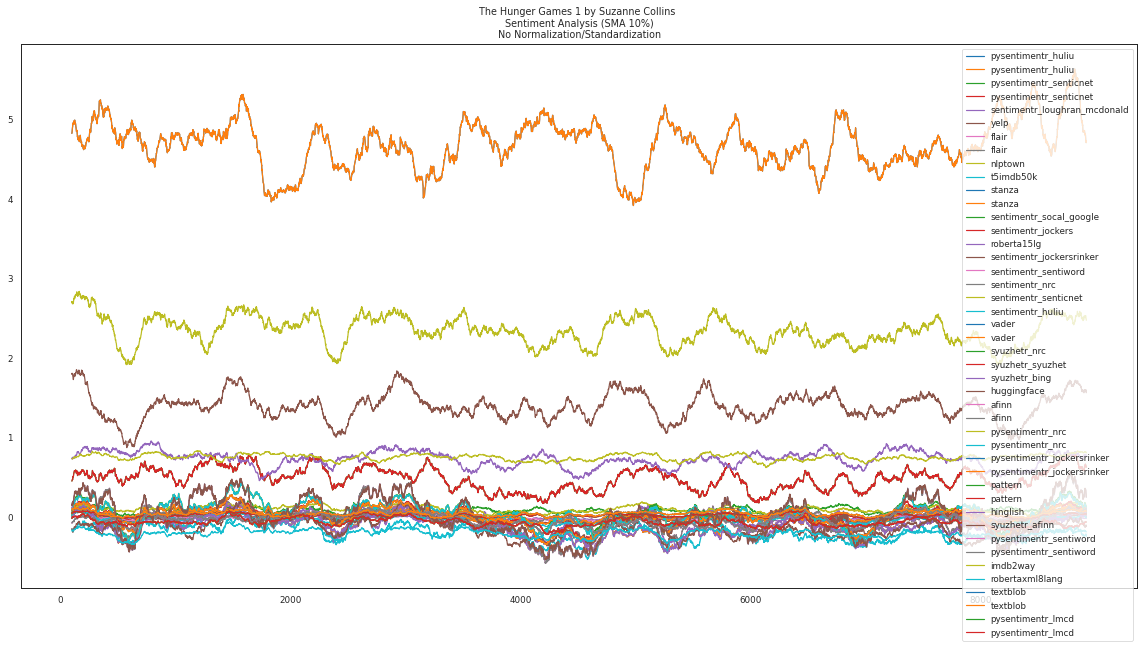

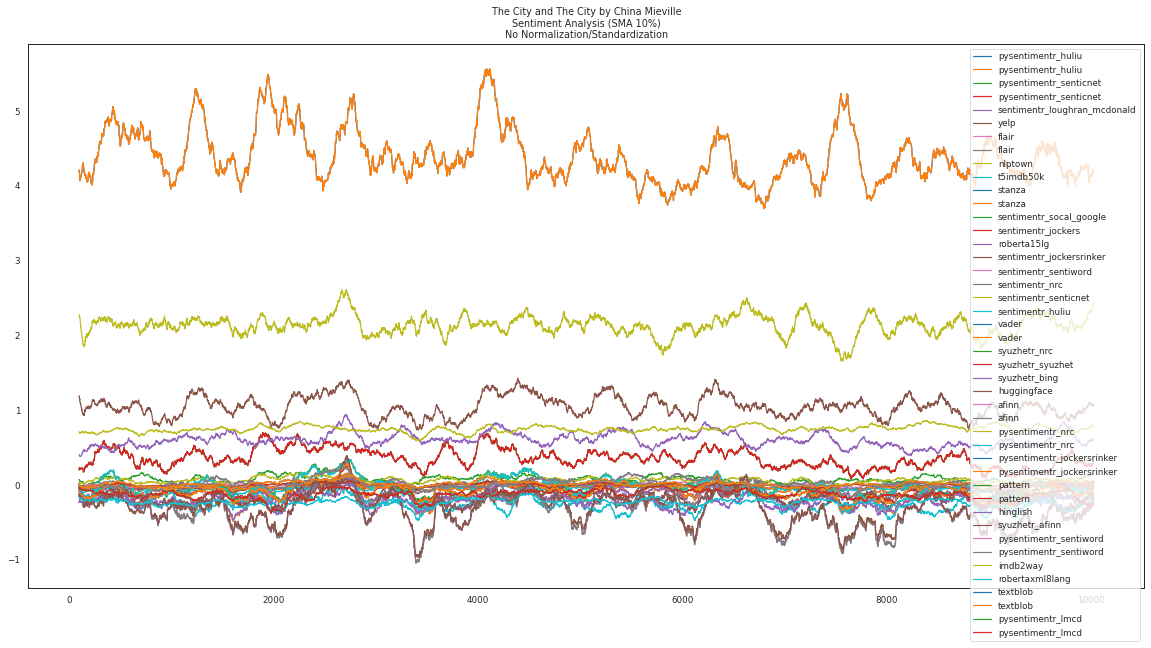

In [22]:
for i, atext in enumerate(corpus_texts_ls):
    
  atitle = f'{corpus_titles_dt[atext][0]}\nSentiment Analysis (SMA 10%)\nNo Normalization/Standardization'
  corpus_texts_dt[atext][ensemble_ls].rolling(200, center=True).mean().plot(title=atitle) 
  plt.show();              

In [ ]:
[SKIP]

In [ ]:
print(f'Trying to find EXISTING Raw Sentiment Datafile:\n  [{FNAME_SENTIMENT_RAW}]\n  in Raw Sentiment Subdir: {SUBDIR_SENTIMENT_RAW}\n')

corpus_texts_dt = {}
subdir_sentiment_raw_ls = os.listdir(SUBDIR_SENTIMENT_RAW)

if FNAME_SENTIMENT_RAW not in subdir_sentiment_raw_ls:
  # No Existing Raw Sentiment Data, Just read in Clean Text
  print(f'No EXISTING Raw Sentiment Datafile exists, Start from Stratch...\n')

  # Create a List (preprocessed_ls) of all preprocessed text files
  try:
    preprocessed_ls = glob(f'{SUBDIR_TEXT_CLEAN}*.csv')
    preprocessed_ls = [x.split('/')[-1] for x in preprocessed_ls]
    preprocessed_ls = [x.split('.')[0] for x in preprocessed_ls]
  except IndexError:
    raise RuntimeError('No csv file found')

  # Read all preprocessed text files into master DataFrame (corpus_dt)
  for i,anovel in enumerate(preprocessed_ls):
    print(f'Processing #{i}: {anovel}...')
    afile_fullpath = f'{SUBDIR_TEXT_CLEAN}{anovel}.csv'
    print(f'               {afile_fullpath}')
    anovel_df = pd.read_csv(afile_fullpath, index_col=[0])
    corpus_texts_dt[anovel] = anovel_df

  print('\n'.join(preprocessed_ls))
  print('\n')
  print(f'Found {len(preprocessed_ls)} Preprocessed files in {SUBDIR_TEXT_CLEAN}')
else:
  # Found Existing Raw Sentiment Data with Clean Text, Read Both
  print(f'Found EXISTING  Raw Sentiment Datafile exists, Loading...\n')
  corpus_texts_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
  print(f'The  Models have Analyzed these Texts in the Corpus:\n\n  {corpus_texts_dt.keys()}\n\n')    

# Verify Corpus DataFrame
corpus_titles_ls = list(corpus_texts_dt.keys())
# corpus_texts_dt[corpus_titles_ls[0]].head()
corpus_texts_dt[corpus_titles_ls[0]].info()

Trying to find EXISTING Raw Sentiment Datafile:
  [sentiment_raw_novels_new_dnn2transformer.json]
  in Raw Sentiment Subdir: ./sentiment_raw/novels_sentiment_new_raw/

Found EXISTING  Raw Sentiment Datafile exists, Loading...

The  Models have Analyzed these Texts in the Corpus:

  dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hinglish         10125 non-null  int64  
 1   huggingface      10125 non-null  float64
 2   imdb2way         10125 non-null  int64  
 3   nlptown          10125 non-null  float64
 4   roberta15lg      10125 non-null  float64
 5   robertaxml8lang  10125 non-null  float64
 6   t5imdb50k        10125 non-null  int64  
 7   text_clean       10125 non-null  object 
 8   text_raw         10125 non-null  object 
 9   yelp             10125 n

# **[STEP 4] Time Series Processing**

## Check for Clean DataFrame

In [23]:
# Check for NaN values

corpus_texts_dt[atext].isnull().values.any()

False

In [24]:
corpus_texts_dt[atext].columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False,  True,  True, False])

In [25]:
print(corpus_texts_dt[atext].columns.value_counts())

text_raw                        4
text_clean                      4
pysentimentr_sentiword          2
flair                           2
vader                           2
textblob                        2
stanza                          2
afinn                           2
pysentimentr_senticnet          2
pysentimentr_nrc                2
pysentimentr_lmcd               2
pysentimentr_jockersrinker      2
pysentimentr_huliu              2
pattern                         2
syuzhetr_nrc                    1
t5imdb50k                       1
robertaxml8lang                 1
roberta15lg                     1
nlptown                         1
imdb2way                        1
huggingface                     1
hinglish                        1
syuzhetr_syuzhet                1
sentimentr_loughran_mcdonald    1
syuzhetr_bing                   1
syuzhetr_afinn                  1
sentimentr_socal_google         1
sentimentr_sentiword            1
sentimentr_senticnet            1
sentimentr_nrc

In [26]:
next(iter(zip(corpus_texts_dt[atext].columns.duplicated(), corpus_texts_dt[atext].columns)))

(False, 'afinn')

In [27]:
df = corpus_texts_dt[atext]
df is corpus_texts_dt[atext]

True

In [28]:
# Check for Duplicate Models/Col names
column_list = pd.Series()

for atext_no in range(len(corpus_texts_dt.keys())):
  df = corpus_texts_dt[atext]
  atext = corpus_texts_ls[atext_no]
  print(f'\n\n\nProcessing #{atext_no}: {atext}')
  # col_dups_ct = corpus_texts_dt[atext].columns.duplicated().sum()
  # col_dups_ls = corpus_texts_dt[atext].columns[corpus_texts_dt[atext].columns.duplicated()]

  col_dups_ct = df.columns.duplicated().sum()

  if col_dups_ct > 0:
    col_dups_ls = df.columns[df.columns.duplicated()]
    print(f'\nBEFORE: {col_dups_ct} duplicated columns')
    print(f'  {", ".join(col_dups_ls)}')  

    # get names of duplicated columns
    column_list = df.columns.value_counts()
    col_del_ls = column_list[column_list>1]
    col_del_ls

    # Add '_dup' suffix to columns repeated more than once (keep one original without _dup suffix)
    my_suffix = '_dup'
    df.columns = [name if (duplicated == False & ~(name.endswith('_dup'))) else name + my_suffix for duplicated, name in zip(df.columns.duplicated(), df.columns)]

    # Drop all columns with '_dup' suffix
    col_drop_ls = [x for x in df.columns if x.endswith('_dup')]
    df.drop(columns=col_drop_ls, inplace=True)

    # check to see if table has duplicate column names which prohibits upload to BigQuery - TRUE Desired
    len(df.columns) == len(set(df.columns))

  else:
    print(f'No Duplicated Columns')




Processing #0: scollins_thehungergames1

BEFORE: 18 duplicated columns
  text_clean, text_raw, afinn, flair, pattern, pysentimentr_huliu, pysentimentr_jockersrinker, pysentimentr_lmcd, pysentimentr_nrc, pysentimentr_senticnet, pysentimentr_sentiword, stanza, text_clean, text_raw, textblob, vader, text_clean, text_raw


text_raw                      4
text_clean                    4
pysentimentr_sentiword        2
flair                         2
vader                         2
textblob                      2
stanza                        2
afinn                         2
pysentimentr_senticnet        2
pysentimentr_nrc              2
pysentimentr_lmcd             2
pysentimentr_jockersrinker    2
pysentimentr_huliu            2
pattern                       2
dtype: int64

True




Processing #1: cmieville_thecityandthecity

BEFORE: 18 duplicated columns
  text_clean, text_raw, afinn, flair, pattern, pysentimentr_huliu, pysentimentr_jockersrinker, pysentimentr_lmcd, pysentimentr_nrc, pysentimentr_senticnet, pysentimentr_sentiword, stanza, text_clean, text_raw, textblob, vader, text_clean, text_raw


text_raw                      4
text_clean                    4
pysentimentr_sentiword        2
flair                         2
vader                         2
textblob                      2
stanza                        2
afinn                         2
pysentimentr_senticnet        2
pysentimentr_nrc              2
pysentimentr_lmcd             2
pysentimentr_jockersrinker    2
pysentimentr_huliu            2
pattern                       2
dtype: int64

True

In [29]:
corpus_texts_dt[atext].columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [30]:
corpus_texts_dt[atext].columns

Index(['afinn', 'flair', 'pattern', 'pysentimentr_huliu',
       'pysentimentr_jockersrinker', 'pysentimentr_lmcd', 'pysentimentr_nrc',
       'pysentimentr_senticnet', 'pysentimentr_sentiword', 'stanza',
       'text_clean', 'text_raw', 'textblob', 'vader', 'sentimentr_huliu',
       'sentimentr_jockers', 'sentimentr_jockersrinker',
       'sentimentr_loughran_mcdonald', 'sentimentr_nrc',
       'sentimentr_senticnet', 'sentimentr_sentiword',
       'sentimentr_socal_google', 'syuzhetr_afinn', 'syuzhetr_bing',
       'syuzhetr_nrc', 'syuzhetr_syuzhet', 'hinglish', 'huggingface',
       'imdb2way', 'nlptown', 'roberta15lg', 'robertaxml8lang', 't5imdb50k',
       'yelp'],
      dtype='object')

In [ ]:
# [SKIP]

In [209]:
print(column_list[column_list>1])

text_clean_dup    3
text_raw_dup      3
dtype: int64


In [155]:
# Drop Duplicated Models/Columns for each Text in Corpus

for atext_no in range(len(corpus_texts_dt.keys())):
  atext = corpus_texts_ls[atext_no]
  print(f'\n\n\nProcessing #{atext_no}: {atext}')
  col_dups_ct = corpus_texts_dt[atext].columns.duplicated().sum()
  col_dups_ls = corpus_texts_dt[atext].columns[corpus_texts_dt[atext].columns.duplicated()]
  print(f'\nBEFORE: {col_dups_ct} duplicated columns')
  print(f'  {", ".join(col_dups_ls)}')

  # if corpus_texts_dt[atext].isnull().values.any()
  # corpus_texts_dt[atext].T.drop_duplicates(keep='last', inplace=True, ignore_index=True).T
  corpus_texts_dt[corpus_texts_ls[atext_no]].T.drop_duplicates(keep='last', inplace=True, ignore_index=True)

  # corpus_texts_dt[atext] = corpus_texts_dt[atext].loc[:,~df.T.duplicated(keep='first')]
  # corpus_texts_dt[atext].T.drop_duplicates(keep='first', inplace=True, ignore_index=True).T # [:,~df.T.duplicated(keep='first')]
  print('\nAFTER:')
  corpus_texts_dt[atext].columns.duplicated()




Processing #0: scollins_thehungergames1

BEFORE: 1 duplicated columns
  flair

AFTER:


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False])




Processing #1: cmieville_thecityandthecity

BEFORE: 1 duplicated columns
  flair

AFTER:


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False])

In [210]:
corpus_texts_dt[corpus_texts_ls[atext_no]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   afinn                         10125 non-null  float64
 1   flair                         10125 non-null  float64
 2   pattern                       10125 non-null  float64
 3   pysentimentr_huliu            10125 non-null  float64
 4   pysentimentr_jockersrinker    10125 non-null  float64
 5   pysentimentr_lmcd             10125 non-null  float64
 6   pysentimentr_nrc              10125 non-null  float64
 7   pysentimentr_senticnet        10125 non-null  float64
 8   pysentimentr_sentiword        10125 non-null  float64
 9   stanza                        10125 non-null  float64
 10  text_clean                    10125 non-null  object 
 11  text_raw                      10125 non-null  object 
 12  textblob                      10125 non-null  float64
 13  v

In [211]:
corpus_texts_dt[corpus_texts_ls[atext_no]].iloc[:,26]

0        0
1        0
2        2
3        2
4        2
        ..
10120    0
10121    0
10122    2
10123    0
10124    0
Name: hinglish, Length: 10125, dtype: int64

In [214]:
corpus_texts_dt[corpus_titles_ls[0]].columns

Index(['afinn', 'flair', 'pattern', 'pysentimentr_huliu',
       'pysentimentr_jockersrinker', 'pysentimentr_lmcd', 'pysentimentr_nrc',
       'pysentimentr_senticnet', 'pysentimentr_sentiword', 'stanza',
       'text_clean', 'text_raw', 'textblob', 'vader', 'sentimentr_huliu',
       'sentimentr_jockers', 'sentimentr_jockersrinker',
       'sentimentr_loughran_mcdonald', 'sentimentr_nrc',
       'sentimentr_senticnet', 'sentimentr_sentiword',
       'sentimentr_socal_google', 'syuzhetr_afinn', 'syuzhetr_bing',
       'syuzhetr_nrc', 'syuzhetr_syuzhet', 'hinglish', 'huggingface',
       'imdb2way', 'nlptown', 'roberta15lg', 'robertaxml8lang', 't5imdb50k',
       'yelp'],
      dtype='object')

In [212]:
indx_eq = np.where(corpus_texts_dt[corpus_texts_ls[atext_no]].iloc[:,1] == corpus_texts_dt[corpus_texts_ls[atext_no]].iloc[:,26], True, False)
np.sum(indx_eq != True)

10125

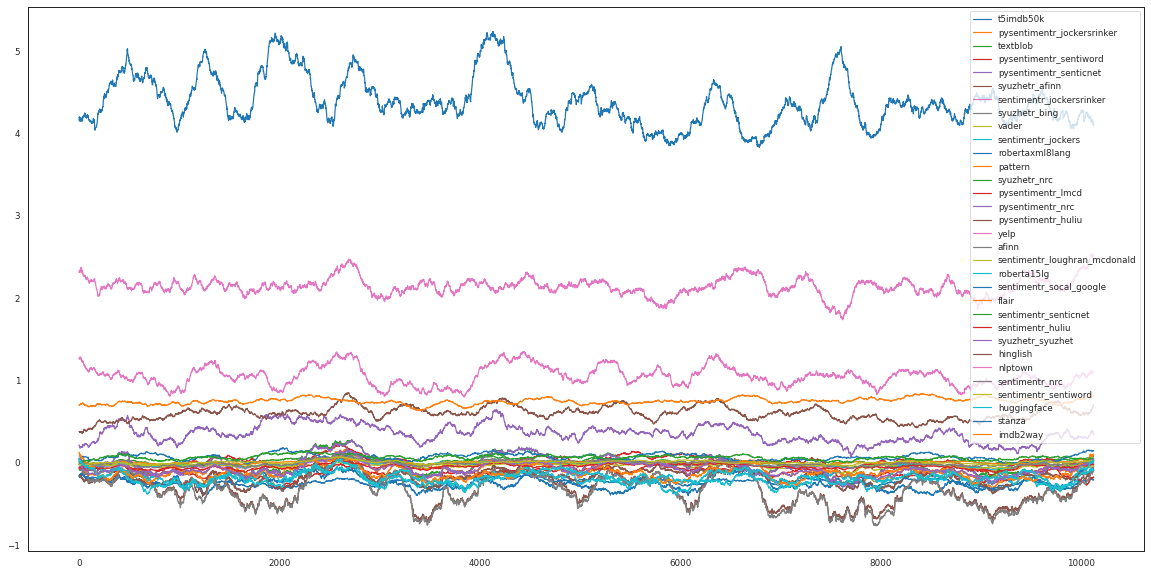

In [215]:
corpus_texts_dt[corpus_texts_ls[atext_no]][ensemble_ls].rolling(300, center=True, min_periods=0).mean().plot();


In [ ]:
# [SKIP]

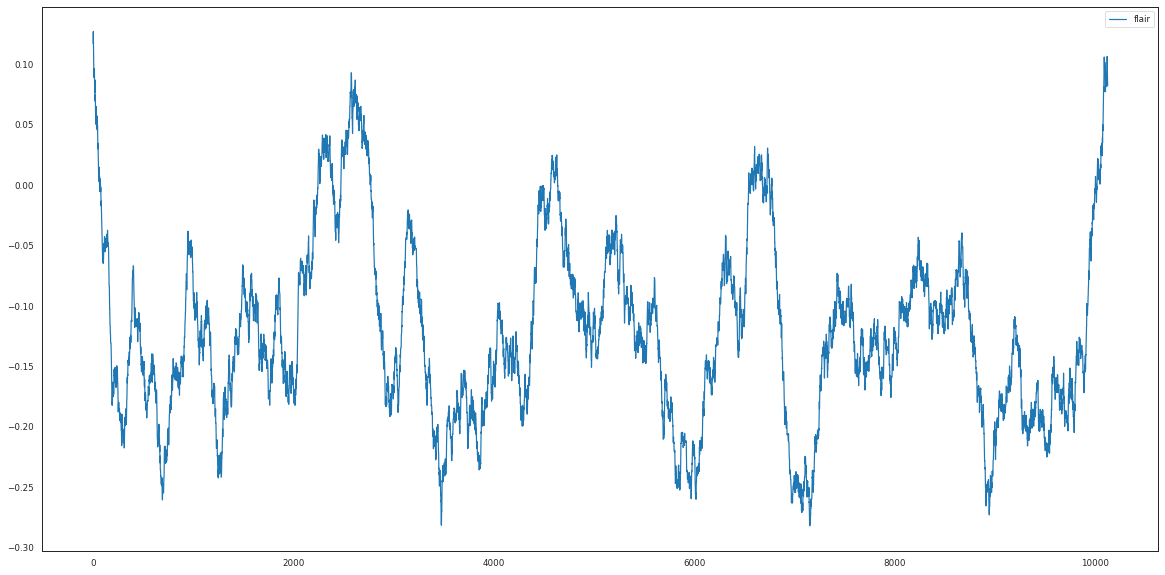

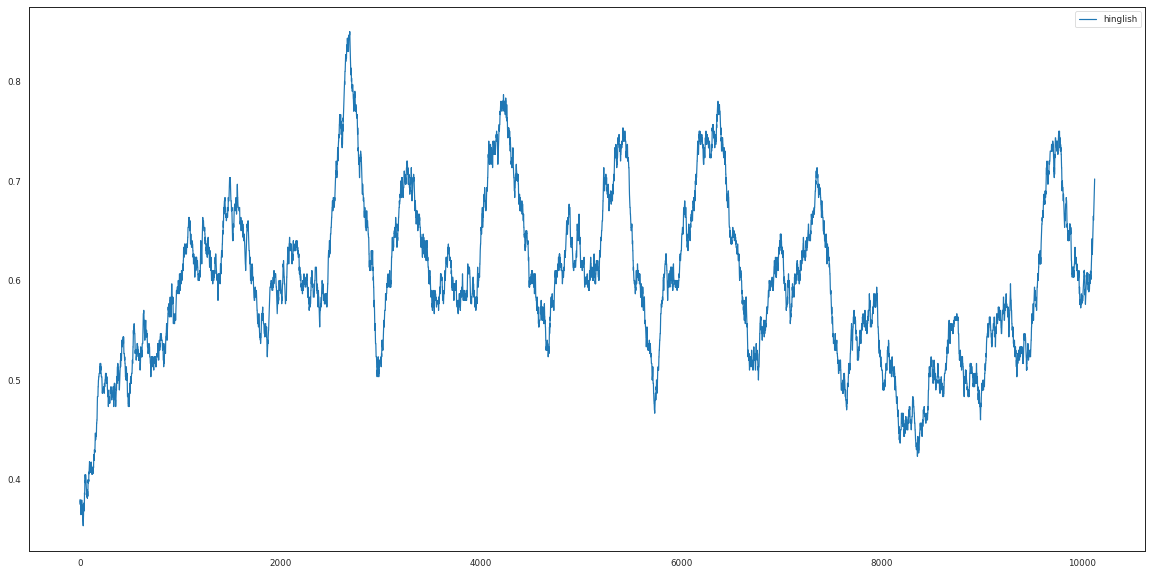

In [213]:
corpus_texts_dt[corpus_texts_ls[atext_no]].iloc[:,[1]].rolling(300, center=True, min_periods=0).mean().plot()

corpus_texts_dt[corpus_texts_ls[atext_no]].iloc[:,[26]].rolling(300, center=True, min_periods=0).mean().plot()

In [148]:
corpus_texts_dt[corpus_texts_ls[atext_no]].iloc[:,26])[indx_eq]

TypeError: ignored

In [141]:
len(C)

10125

In [144]:
list(pd.Series(corpus_texts_dt[corpus_texts_ls[atext_no]].iloc[:,1])[C])

[0.8531,
 -0.6146,
 -0.7487,
 0.9984,
 0.9982,
 0.9984,
 0.9995,
 0.9998,
 0.9955,
 0.9963,
 0.9971,
 0.9977,
 0.9952,
 0.9937,
 0.9948,
 0.9951,
 0.9943,
 0.9943,
 0.9965,
 0.9941,
 0.9941,
 0.9967,
 0.9933,
 0.9959,
 0.9908,
 0.9931,
 0.9923,
 0.9937,
 0.9927,
 0.998,
 0.9934,
 0.9949,
 0.9926,
 0.9914,
 0.9904,
 0.8768,
 0.9986,
 0.9957,
 -0.9921,
 -0.6686,
 -0.6262,
 -0.9982,
 -0.9987,
 -0.9819,
 -0.9813,
 0.9435,
 0.9119,
 -0.8123,
 0.8116,
 -0.9476,
 0.7261,
 -0.7293,
 -0.8071,
 0.8667,
 -0.9996,
 0.7042,
 -0.9995,
 -0.9998,
 -0.9985,
 -0.9996,
 0.9519,
 -0.9808,
 0.9866,
 -0.9849,
 0.988,
 -0.6842,
 -0.9931,
 -0.7955,
 -0.9931,
 -0.999,
 0.9063,
 0.9393,
 0.9695,
 0.5241,
 -0.9479,
 -0.9977,
 0.9771,
 0.998,
 -1.0,
 -0.9997,
 -0.9893,
 -0.9222,
 0.952,
 -0.995,
 -0.9822,
 -0.9943,
 -0.9076,
 0.9284,
 0.9617,
 -0.6217,
 0.9964,
 -0.9381,
 0.9981,
 0.8385,
 0.7239,
 -0.9997,
 0.9918,
 0.8988,
 0.9959,
 0.8488,
 0.6896,
 -0.9962,
 0.756,
 -0.9935,
 -0.9969,
 -0.9794,
 0.9966,
 -0.7

In [118]:
# Drop Duplicated Models/Columns for each Text in Corpus

for atext_no in range(len(corpus_texts_dt.keys())):
  atext = corpus_texts_ls[atext_no]
  print(f'Processing #{atext_no}: {atext}')
  col_dups_ct = corpus_texts_dt[atext].columns.duplicated().sum()
  col_dups_ls = corpus_texts_dt[atext].columns[corpus_texts_dt[atext].columns.duplicated()]
  print(f'\n\nBEFORE: {col_dups_ct} duplicated columns')
  print(f'  {", ".join(col_dups_ls)}\n\n')
  corpus_texts_dt[atext].columns.duplicated()
  # corpus_texts_dt[atext] = corpus_texts_dt[atext].loc[:,~df.T.duplicated(keep='first')]
  corpus_texts_dt[atext].T.drop_duplicates(keep='first', inplace=True, ignore_index=True).T # [:,~df.T.duplicated(keep='first')]
  print('\n\nAFTER:')
  corpus_texts_dt[atext].columns.duplicated()

Processing #0: scollins_thehungergames1


BEFORE: 1 duplicated columns
  flair




array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False])

AttributeError: ignored

In [ ]:
df = corpus_texts_dt[corpus_texts_ls[0]]
df = df.loc[:,~df.columns.duplicated()]
df.columns

## Standardize and Normalize

ser_median = 12.5
ser_mad = 11.119516638792014
ser_max = 24
ser_min = 1
ser_upperlim = 40.29879159698004
ser_lowerlim = -15.298791596980035
ser_median = 0.0
ser_mad = 0.11445689126863248
ser_max = 1.9808000000000001
ser_min = -2.5205
ser_upperlim = 0.2861422281715812
ser_lowerlim = -0.2861422281715812
new min is -0.2861422281715812
new max is 0.2861422281715812


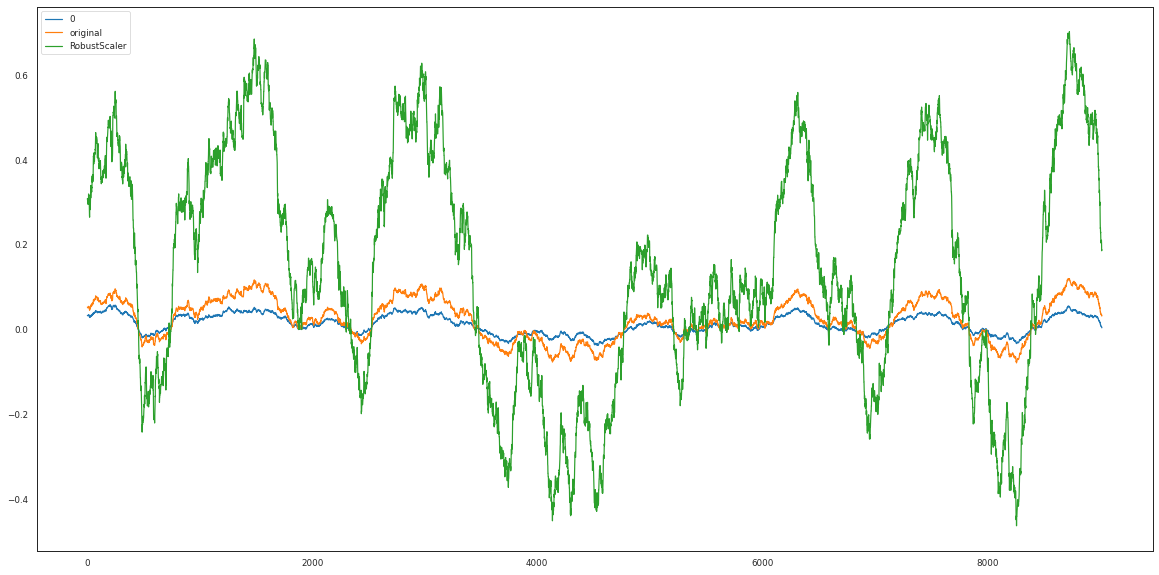

In [31]:
# Clip Outliers based on IQR: RobustScaler())

def clip_outliers(floats_ser):
  '''
  Given a pd.Series of float values
  Return a list with outliers removed, values limited within 3 median absolute deviations from median
  '''
  # https://www.statsmodels.org/stable/generated/statsmodels.robust.scale.mad.html#statsmodels.robust.scale.mad

  # Old mean/std, less robust
  # ser_std = floats_ser.std()
  # ser_median = floats_ser.mean() # TODO: more robust: asym/outliers -> median/IQR or median/median abs deviation

  floats_np = np.array(floats_ser)
  ser_median = floats_ser.median()
  ser_mad = sm_robust.mad(floats_np)
  print(f'ser_median = {ser_median}')
  print(f'ser_mad = {ser_mad}')

  if ser_mad == 0:
    # for TS with small ranges (e.g. -1.0 to +1.0) Median Abs Deviation = 0
    #   so pass back the original time series
    floats_clip_ls = list(floats_ser)

  else:
    ser_oldmax = floats_ser.max()
    ser_oldmin = floats_ser.min()
    print(f'ser_max = {ser_oldmax}')
    print(f'ser_min = {ser_oldmin}')

    ser_upperlim = ser_median + 2.5*ser_mad
    ser_lowerlim = ser_median - 2.5*ser_mad
    print(f'ser_upperlim = {ser_upperlim}')
    print(f'ser_lowerlim = {ser_lowerlim}')

    # Clip outliers to max or min values
    floats_clip_ls = np.clip(floats_np, ser_lowerlim, ser_upperlim)
    # print(f'max floast_ls {floats_ls.max()}')

    # def map2range(value, low, high, new_low, new_high):
    #   '''map a value from one range to another'''
    #   return value * 1.0 / (high - low + 1) * (new_high - new_low + 1)

    # Map all float values to range [-1.0 to 1.0]
    # floats_clip_sig_ls = [map2range(i, ser_oldmin, ser_oldmax, ser_upperlim, ser_lowerlim) for i in floats_clip_ls]

    # listmax_fl = float(max(floats_ls))
    # floats_ls = [i/listmax_fl for i in floats_ls]
    #floats_ls = [1/(1+math.exp(-i)) for i in floats_ls]

  return floats_clip_ls  # floats_clip_sig_ls

# Test
# Will not work on first run as corpus_sents_df is not defined yet

data = np.array([1, 4, 4, 7, 12, 13, 16, 19, 22, 24])
test_ls = clip_outliers(pd.Series(data))
test_ls = clip_outliers(corpus_texts_dt[corpus_texts_ls[0]]['vader'])
# test_ls = clip_outliers(corpus_texts_dt[corpus_texts_ls[0]]['afinn'].iloc[0])
print(f'new min is {min(test_ls)}')
print(f'new max is {max(test_ls)}')

pd.DataFrame(test_ls).rolling(300, center=True, min_periods=0).mean().plot(label='clipped');

corpus_texts_dt[corpus_texts_ls[0]]['vader'].rolling(300, center=True, min_periods=0).mean().plot(label='original')

# transformer = scaler_robust.fit(corpus_texts_dt[corpus_texts_ls[0]]['vader'].values.reshape(-1, 1))

test_df = corpus_texts_dt[corpus_texts_ls[0]]['vader'].copy(deep=True) #   pd.DataFrame()
# test_df = pd.DataFrame({'vader': scaler_robust.fit_transform(np.array(corpus_texts_dt[corpus_texts_ls[0]]['vader']).reshape(-1, 1))})
test_df['vader_std'] = pd.Series(scaler_robust.fit_transform(np.array(corpus_texts_dt[corpus_texts_ls[0]]['vader']).reshape(-1, 1)).flatten())
test_df['vader_std'].rolling(300, center=True, min_periods=0).mean().plot(label='RobustScaler')

plt.legend()
plt.show();

In [ ]:
# transformer = scaler_robust.fit(corpus_texts_dt[corpus_texts_ls[0]]['vader'].values.reshape(-1, 1))

test_df = corpus_texts_dt[corpus_texts_ls[0]]['vader'].copy(deep=True) #   pd.DataFrame()
# test_df = pd.DataFrame({'vader': scaler_robust.fit_transform(np.array(corpus_texts_dt[corpus_texts_ls[0]]['vader']).reshape(-1, 1))})
test_df['vader_std'] = pd.Series(scaler_robust.fit_transform(np.array(corpus_texts_dt[corpus_texts_ls[0]]['vader']).reshape(-1, 1)).flatten())
test_df['vader_std'].rolling(300, center=True, min_periods=0).mean().plot(label='RobustScaler')

plt.legend()
plt.show();

Text #0: cmieville_thecityandthecity
  Model #0: pysentimentr_huliu (Model_Std: pysentimentr_huliu_rstd)
  Model #1: pysentimentr_senticnet (Model_Std: pysentimentr_senticnet_rstd)
  Model #2: sentimentr_loughran_mcdonald (Model_Std: sentimentr_loughran_mcdonald_rstd)
  Model #3: yelp (Model_Std: yelp_rstd)
  Model #4: flair (Model_Std: flair_rstd)
  Model #5: nlptown (Model_Std: nlptown_rstd)
  Model #6: t5imdb50k (Model_Std: t5imdb50k_rstd)
  Model #7: stanza (Model_Std: stanza_rstd)
  Model #8: sentimentr_socal_google (Model_Std: sentimentr_socal_google_rstd)
  Model #9: sentimentr_jockers (Model_Std: sentimentr_jockers_rstd)
  Model #10: roberta15lg (Model_Std: roberta15lg_rstd)
  Model #11: sentimentr_jockersrinker (Model_Std: sentimentr_jockersrinker_rstd)
  Model #12: sentimentr_sentiword (Model_Std: sentimentr_sentiword_rstd)
  Model #13: sentimentr_nrc (Model_Std: sentimentr_nrc_rstd)
  Model #14: sentimentr_senticnet (Model_Std: sentimentr_senticnet_rstd)
  Model #15: sentime

Text #1: scollins_thehungergames1
  Model #0: pysentimentr_huliu (Model_Std: pysentimentr_huliu_rstd)
  Model #1: pysentimentr_senticnet (Model_Std: pysentimentr_senticnet_rstd)
  Model #2: sentimentr_loughran_mcdonald (Model_Std: sentimentr_loughran_mcdonald_rstd)
  Model #3: yelp (Model_Std: yelp_rstd)
  Model #4: flair (Model_Std: flair_rstd)
  Model #5: nlptown (Model_Std: nlptown_rstd)
  Model #6: t5imdb50k (Model_Std: t5imdb50k_rstd)
  Model #7: stanza (Model_Std: stanza_rstd)
  Model #8: sentimentr_socal_google (Model_Std: sentimentr_socal_google_rstd)
  Model #9: sentimentr_jockers (Model_Std: sentimentr_jockers_rstd)
  Model #10: roberta15lg (Model_Std: roberta15lg_rstd)
  Model #11: sentimentr_jockersrinker (Model_Std: sentimentr_jockersrinker_rstd)
  Model #12: sentimentr_sentiword (Model_Std: sentimentr_sentiword_rstd)
  Model #13: sentimentr_nrc (Model_Std: sentimentr_nrc_rstd)
  Model #14: sentimentr_senticnet (Model_Std: sentimentr_senticnet_rstd)
  Model #15: sentimentr

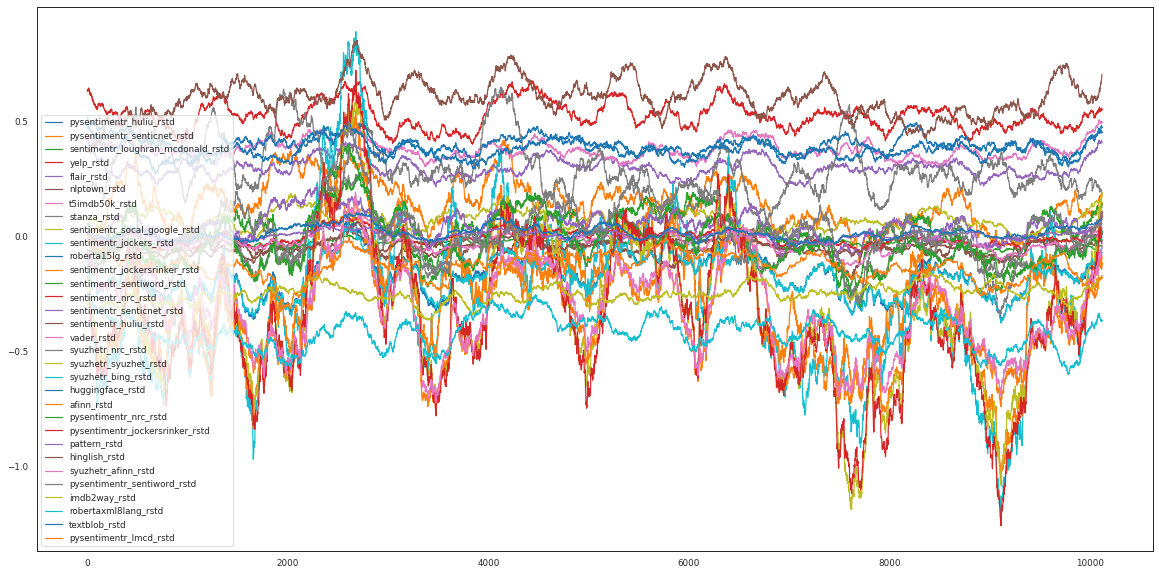

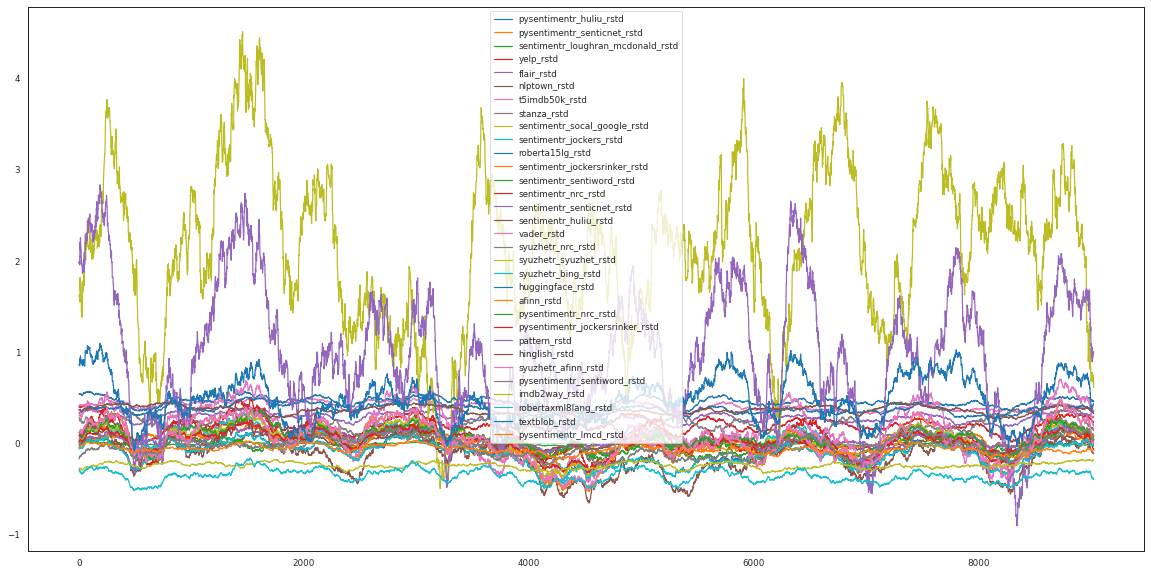

In [41]:
# ScalerRobust

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f'Text #{i}: {atext}')
  
  models_std_ls = []
  for j, amodel in enumerate(ensemble_ls):
    amodel_std = f'{amodel}_rstd'
    print(f'  Model #{j}: {amodel} (Model_Std: {amodel_std})')
    # clip_outliers(corpus_texts_dt[corpus_texts_ls[0]]['vader'])
    # corpus_texts_dt[atext][amodel_std] = pd.Series(clip_outliers(corpus_texts_dt[atext][amodel])) # .reshape(-1,1)).flatten())
    # scikit ScalerRobust doesn't normalize well
    corpus_texts_dt[atext][amodel_std] = pd.Series(scaler_robust.fit_transform(np.array(corpus_texts_dt[atext][amodel]).reshape(-1,1)).flatten())
    models_std_ls.append(amodel_std)

  corpus_texts_dt[atext][models_std_ls].rolling(300, center=True, min_periods=0).mean().plot(label='clipped')

Text #0: cmieville_thecityandthecity


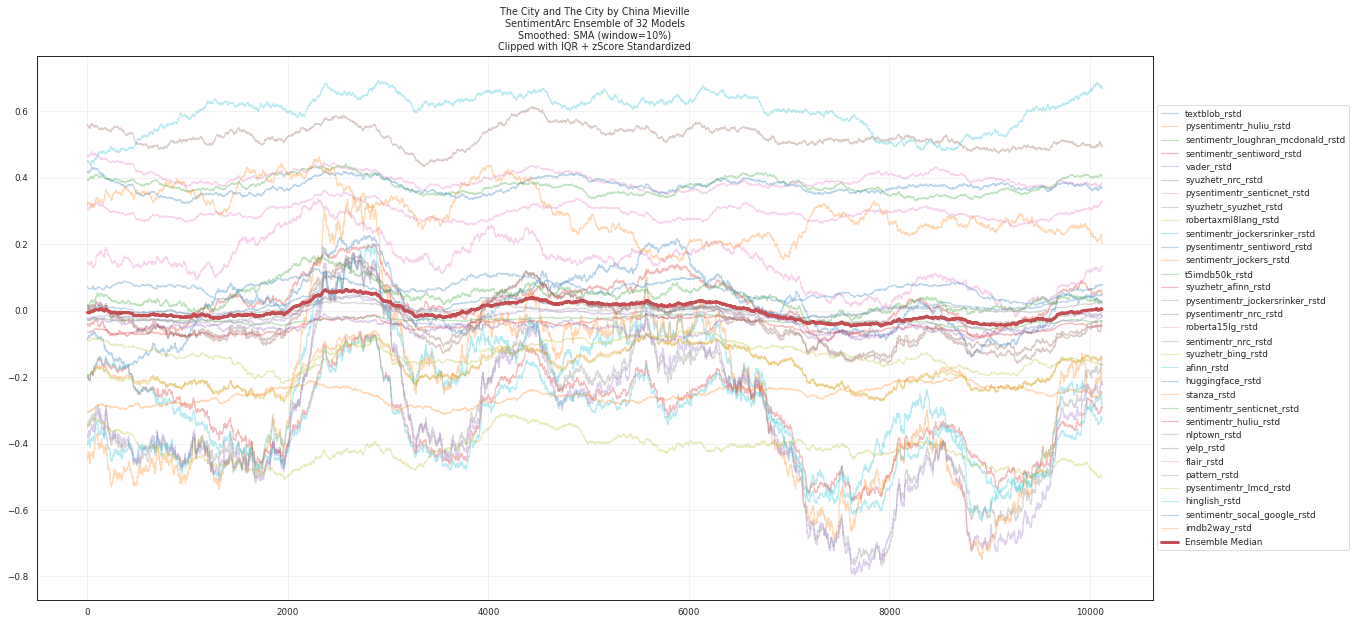

Text #1: scollins_thehungergames1


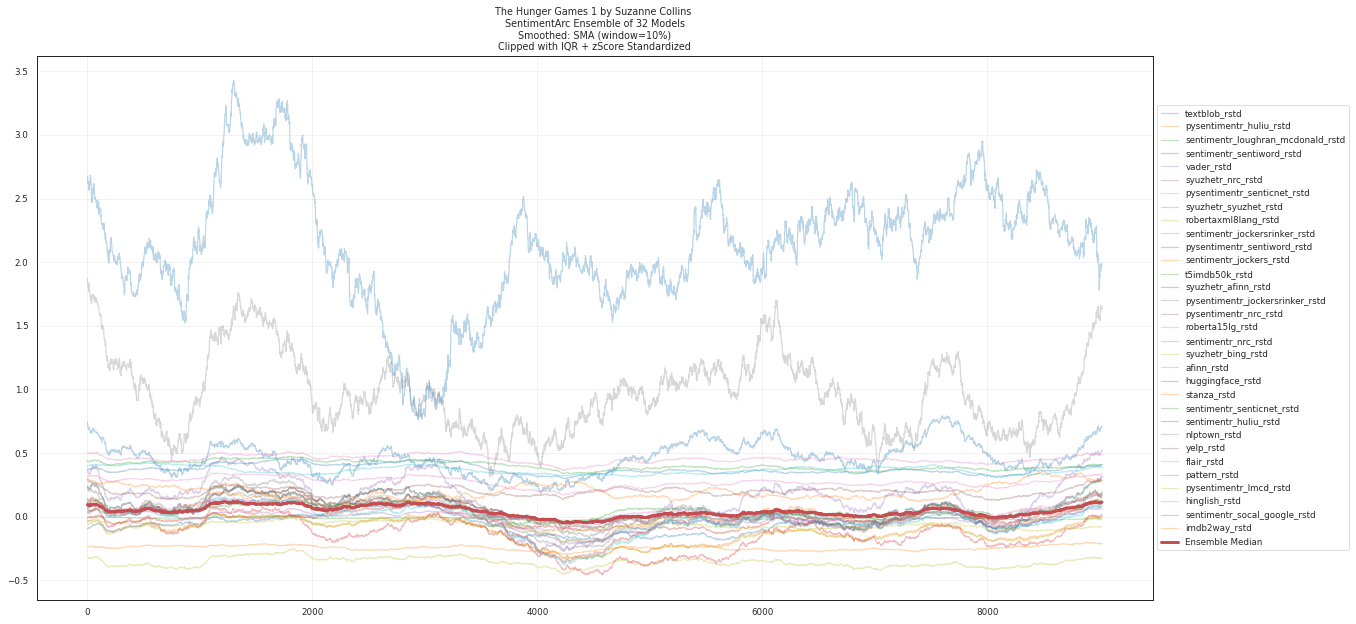

In [42]:
# Clip_Outliers

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f'Text #{i}: {atext}')
  
  models_std_ls = []
  for j, amodel in enumerate(ensemble_ls):
    amodel_std = f'{amodel}_rstd'
    print(f'  Model #{j}: {amodel} (Model_Std: {amodel_std})')
    # clip_outliers(corpus_texts_dt[corpus_texts_ls[0]]['vader'])
    corpus_texts_dt[atext][amodel_std] = pd.Series(clip_outliers(corpus_texts_dt[atext][amodel])) # .reshape(-1,1)).flatten())
    # scikit ScalerRobust doesn't normalize well
    # corpus_texts_dt[atext][amodel_std] = pd.Series(scaler_robust.fit_transform(np.array(corpus_texts_dt[atext][amodel]).reshape(-1,1)).flatten())
    models_std_ls.append(amodel_std)

  corpus_texts_dt[atext][models_std_ls].rolling(300, center=True, min_periods=0).mean().plot(label='clipped')

In [ ]:
# [SKIP]

In [235]:
scaler_robust.fit(corpus_texts_dt[corpus_texts_ls[0]]['vader'].values.reshape(-1, 1))

RobustScaler()

In [104]:
corpus_texts_dt[corpus_texts_ls[1]]['roberta15lg'].median()
corpus_texts_dt[corpus_texts_ls[1]]['roberta15lg'].mean()

-0.9870992302894592

-0.1957086741777114

In [59]:
ensemble_models_dt['heuristic']

['pattern',
 'sentimentr_jockersrinker',
 'sentimentr_jockers',
 'sentimentr_bing',
 'sentimentr_nrc',
 'sentimentr_sentiword',
 'sentimentr_senticnet',
 'sentimentr_lmcd',
 'vader']

In [65]:
df = corpus_texts_dt[corpus_texts_ls[0]]
df = df.loc[:,~df.columns.duplicated()]
df.columns

Index(['afinn', 'flair', 'pattern', 'pysentimentr_huliu',
       'pysentimentr_jockersrinker', 'pysentimentr_lmcd', 'pysentimentr_nrc',
       'pysentimentr_senticnet', 'pysentimentr_sentiword', 'stanza',
       'text_clean', 'text_raw', 'textblob', 'vader', 'sentimentr_huliu',
       'sentimentr_jockers', 'sentimentr_jockersrinker',
       'sentimentr_loughran_mcdonald', 'sentimentr_nrc',
       'sentimentr_senticnet', 'sentimentr_sentiword',
       'sentimentr_socal_google', 'syuzhetr_afinn', 'syuzhetr_bing',
       'syuzhetr_nrc', 'syuzhetr_syuzhet', 'hinglish', 'huggingface',
       'imdb2way', 'nlptown', 'roberta15lg', 'robertaxml8lang', 't5imdb50k',
       'yelp'],
      dtype='object')

In [66]:
df.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [91]:
corpus_texts_ls

['scollins_thehungergames1', 'cmieville_thecityandthecity']

In [100]:
# Drop Duplicated Models/Columns for each Text in Corpus

for atext_no in range(len(corpus_texts_ls)):
  atext = corpus_texts_ls[atext_no]
  print(f'Processing #{atext_no}: {atext}')
  print('\n\nBEFORE:')
  corpus_texts_dt[atext].columns.duplicated()
  # corpus_texts_dt[atext] = corpus_texts_dt[atext].loc[:,~df.T.duplicated(keep='first')]
  corpus_texts_dt[atext].T.drop_duplicates(keep='first', inplace=True, ignore_index=True).T # [:,~df.T.duplicated(keep='first')]
  print('\n\nAFTER:')
  corpus_texts_dt[atext].columns.duplicated()

Processing #0: scollins_thehungergames1


BEFORE:


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False])

AttributeError: ignored

In [103]:
corpus_texts_dt['scollins_thehungergames1'].shape

(9021, 35)

In [101]:
corpus_texts_dt[corpus_texts_ls[0]].columns

Index(['afinn', 'flair', 'pattern', 'pysentimentr_huliu',
       'pysentimentr_jockersrinker', 'pysentimentr_lmcd', 'pysentimentr_nrc',
       'pysentimentr_senticnet', 'pysentimentr_sentiword', 'stanza',
       'text_clean', 'text_raw', 'textblob', 'vader', 'sentimentr_huliu',
       'sentimentr_jockers', 'sentimentr_jockersrinker',
       'sentimentr_loughran_mcdonald', 'sentimentr_nrc',
       'sentimentr_senticnet', 'sentimentr_sentiword',
       'sentimentr_socal_google', 'syuzhetr_afinn', 'syuzhetr_bing',
       'syuzhetr_nrc', 'syuzhetr_syuzhet', 'flair', 'hinglish', 'huggingface',
       'imdb2way', 'nlptown', 'roberta15lg', 'robertaxml8lang', 't5imdb50k',
       'yelp'],
      dtype='object')

In [105]:
corpus_texts_dt[corpus_texts_ls[0]].columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False])

In [74]:
corpus_texts_dt[corpus_texts_ls[0]]['afinn'].iloc[0]

afinn    2.0
afinn    2.0
Name: 0, dtype: float64

In [68]:
corpus_texts_dt[corpus_texts_ls[0]].columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False,  True,  True, False])

In [ ]:
# zScore Norm: StandardScaler()

def standardize_ts(data_ser):
  '''
  Given a series of floating number
  Return a a list of same values normed between -1.0 and +1.0
  '''
  # data_np = np.matrix(data_ser)

  std_scaler = StandardScaler()
  df_std = std_scaler.fit_transform(np.array(data_ser))
  
  return df_std

# Test
'''
temp_np = norm2negpos1(corpus_all_df[['xlnet_sst5']])
print(type(temp_np))
temp_np.shape
temp_np
''';

## Smoothing

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

for i in xrange(5):
    ax.plot(x, i * x, label='$y = %ix$'%i)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
temp_dt = corpus_texts_dt[corpus_texts_ls[0]][models_std].rolling(win_10per, center=True, min_periods=0).mean()

Text #0: cmieville_thecityandthecity


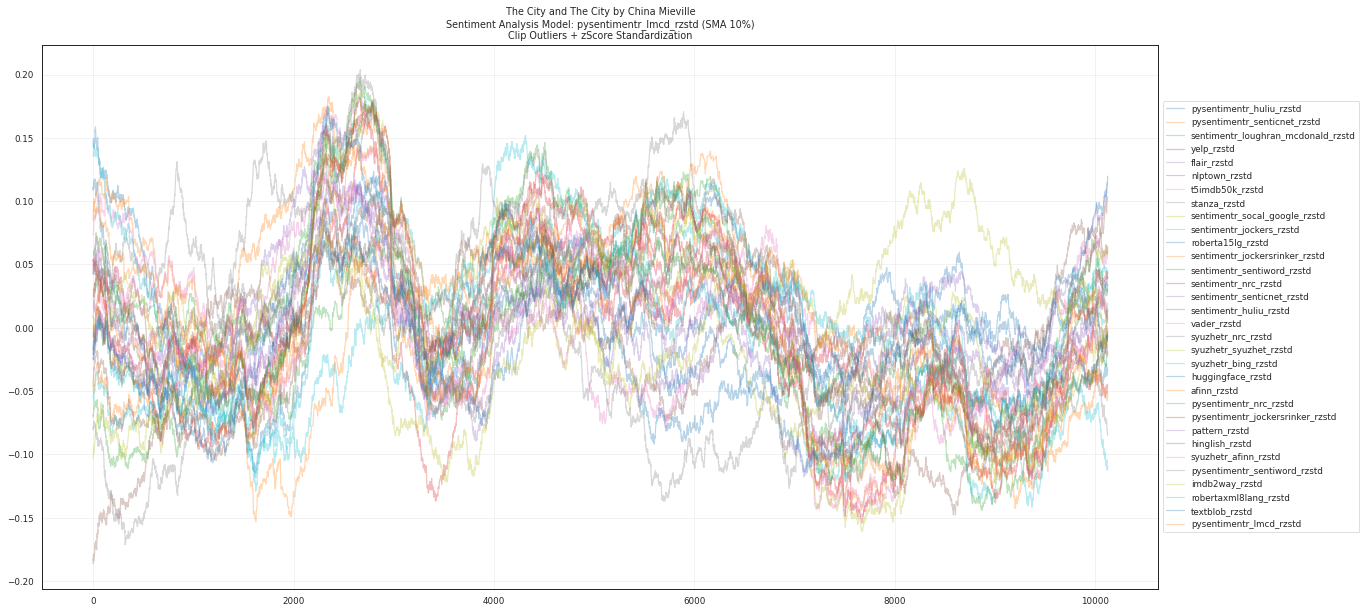

Text #1: scollins_thehungergames1


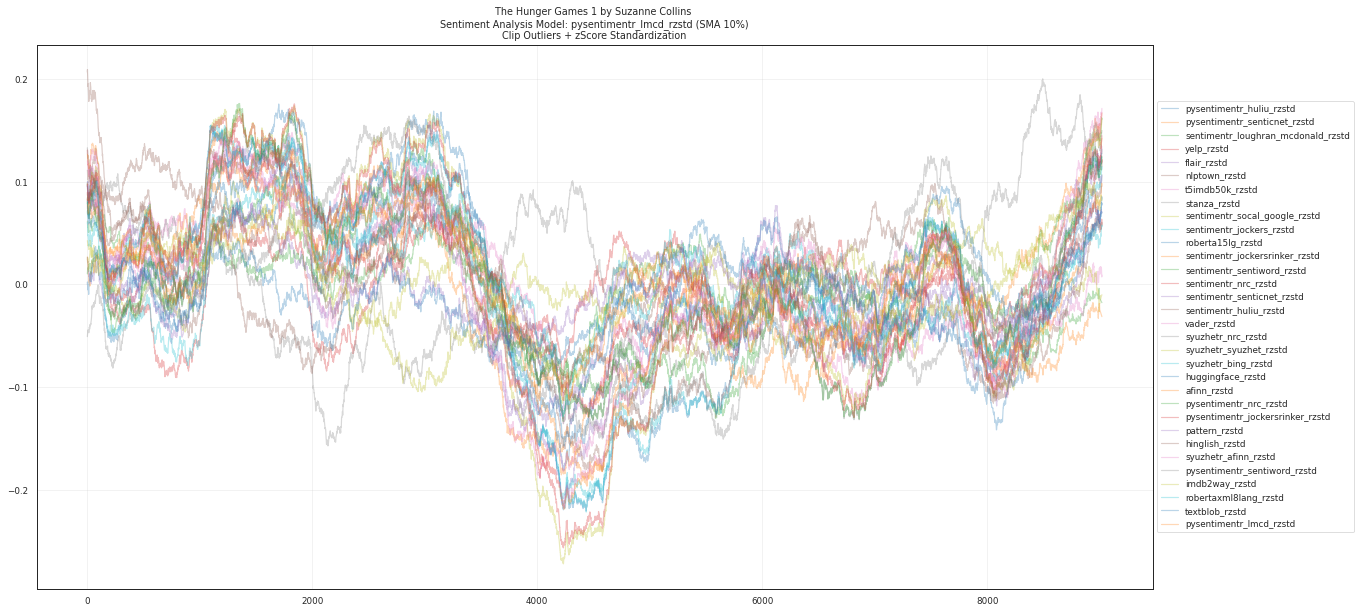

In [50]:
# z-Score Standard Scaling

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f'Text #{i}: {atext}')
  
  models_std_ls = []
  for j, amodel in enumerate(ensemble_ls):
    amodel_std = f'{amodel}_rzstd'
    # print(f'  Model #{j}: {amodel} (Model_Std: {amodel_std})')
    # zScore Normalization with scikit ScalerStandard()
    corpus_texts_dt[atext][amodel_std] = pd.Series(scaler_zscore.fit_transform(np.array(corpus_texts_dt[atext][amodel]).reshape(-1,1)).flatten())
    models_std_ls.append(amodel_std)

  corpus_texts_dt[atext][models_std_ls].rolling(300, center=True, min_periods=0).mean().plot(title=f"{corpus_titles_dt[atext][0]}\nSentiment Analysis Model: {amodel} (SMA 10%)\nClip Outliers + zScore Standardization", alpha=0.3)


  fig = plt.figure()
  ax = plt.subplot(111)

  for j, amodel in enumerate(ensemble_ls):
    amodel_std = f'{amodel}_rzstd'
    win_10per = int(0.10 * corpus_texts_dt[atext].shape[0])
    temp_dt = corpus_texts_dt[atext][models_std].rolling(win_10per, center=True, min_periods=0).mean()
    ax.plot(corpus_texts_dt[atext][amodel_std], label=amodel_std)

  # Shrink current axis by 20%
  # box = ax.get_position()
  # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

  # Put a legend to the right of the current axis
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.show()

Text #0: cmieville_thecityandthecity


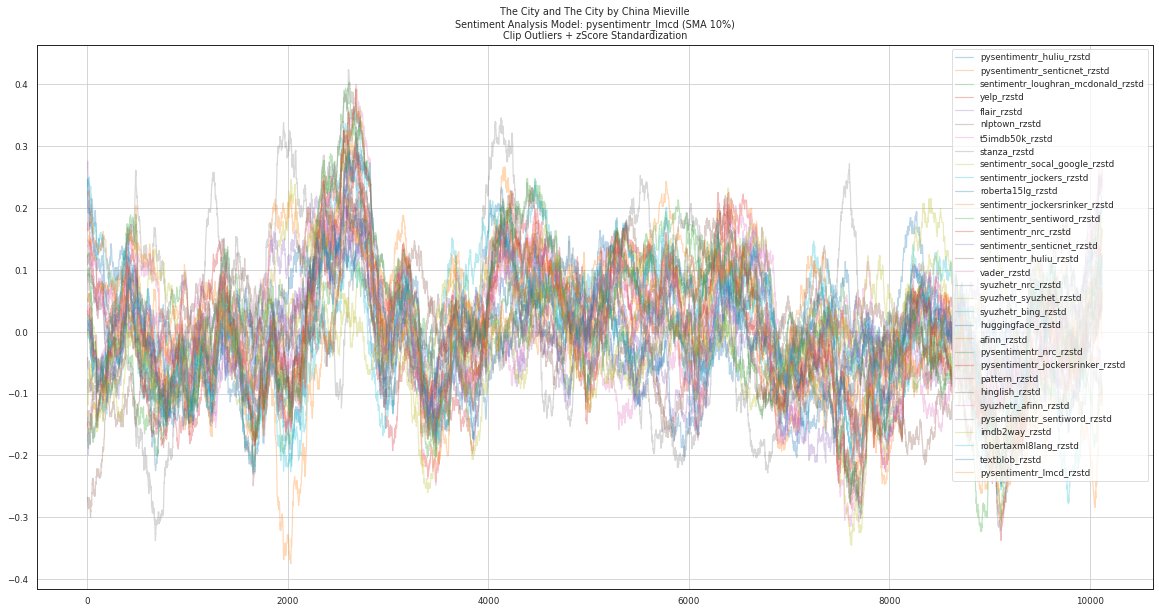

Text #1: scollins_thehungergames1


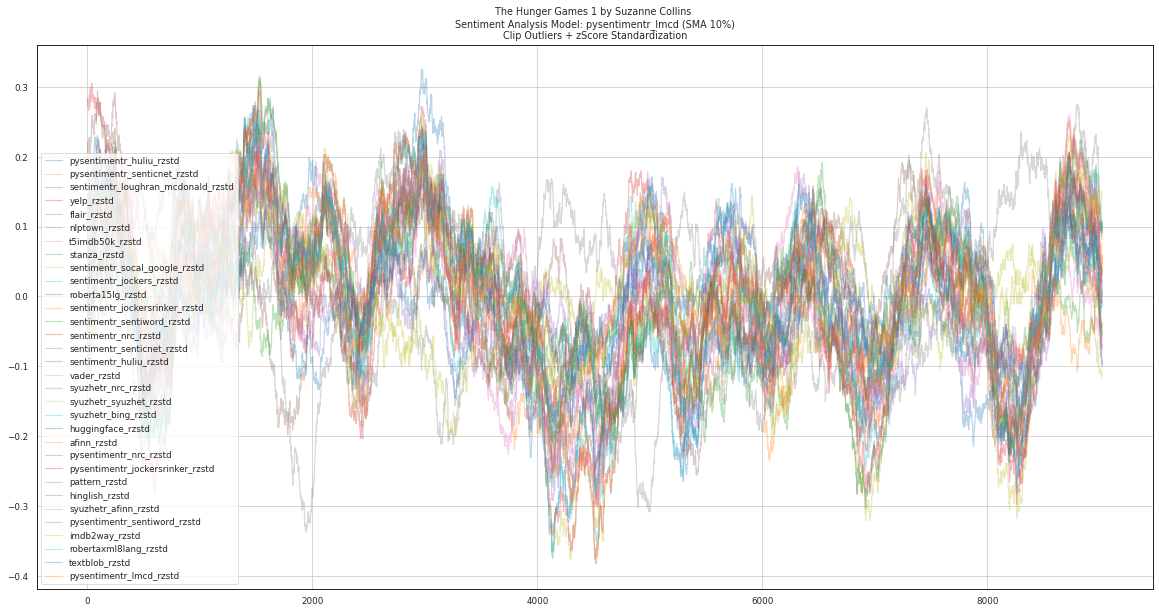

In [48]:
# z-Score Standard Scaling

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f'Text #{i}: {atext}')
  
  models_std_ls = []
  for j, amodel in enumerate(ensemble_ls):
    amodel_std = f'{amodel}_rzstd'
    # print(f'  Model #{j}: {amodel} (Model_Std: {amodel_std})')
    # zScore Normalization with scikit ScalerStandard()
    corpus_texts_dt[atext][amodel_std] = pd.Series(scaler_zscore.fit_transform(np.array(corpus_texts_dt[atext][amodel]).reshape(-1,1)).flatten())
    models_std_ls.append(amodel_std)

  corpus_texts_dt[atext][models_std_ls].rolling(300, center=True, min_periods=0).mean().plot(title=f"{corpus_titles_dt[atext][0]}\nSentiment Analysis Model: {amodel} (SMA 10%)\nClip Outliers + zScore Standardization", alpha=0.3)
  plt.grid(True)
  plt.show();


# **[STEP 5] Time Series and Crux Point Analysis**

* https://github.com/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb


# **END OF NOTEBOOK**